In [269]:
from seirsplus.models import *
import networkx
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from hyperopt import hp
from functools import partial
from matplotlib import pyplot as plt
from hyperopt import fmin, tpe, space_eval, Trials
import math

## Common Function Definitions

In [362]:
#### Since the model outputs a different format than the CSSEGISandData, we need to align them
#### which means - finding the appropriate prediction for the model for a particular date

### modelI - Time Series Prediction output by model (model.numI)
### modelT - Time Series of the model (model.tseries)
### dates  - dates in the true file that we have from CSSEGISandData - datetime object


def alignTimeSeries(modelI, modelT, dates):
#     datesS = ['3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20']
#     dates = []
#     for date in datesS:
#         dates.append(datetime.strptime(date, "%m/%d/%y"))
    finalModelPredictions = []
    count = 0
    day0 = dates[0]
    for date in dates:
        t = (date-day0).days
        #print(t)
        while(modelT[count]<=t):
            count+=1
            if(count == len(modelT)):
                print("Last prediction reached - Number of predictions less than required")
                finalModelPredictions.append(modelI[count-1])
                finalModelPredictions_df = pd.DataFrame()
                finalModelPredictions_df['date'] = [date.strftime('%Y-%m-%d') for date in dates]
                finalModelPredictions_df['predicted_count'] = finalModelPredictions
                return finalModelPredictions_df
            
        diff1 = t - modelT[count-1]
        diff2 = modelT[count] - t
        if(diff1<=diff2):
            finalModelPredictions.append(modelI[count-1])
            count -=1
        else:
            finalModelPredictions.append(modelI[count])
    
    finalModelPredictions_df = pd.DataFrame()
    finalModelPredictions_df['date'] = [date.strftime('%Y-%m-%d') for date in dates]
    finalModelPredictions_df['predicted_count'] = finalModelPredictions
      
    return finalModelPredictions_df

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_mape(orig, pred, index):
    merge = orig.merge(pred, right_on="date", left_on='date')
    merge = merge.dropna()
    print(merge)
    y_true = np.array(merge[index])
    y_pred = np.array(merge["predicted_count"])
    mape = 0
    for i in range(len(y_pred)):
        if(not y_true[i] == 0):
            mape+= np.abs((y_true[i] - y_pred[i] + 0.) / y_true[i])
    mape = (100*mape)/len(y_pred)
    return mape

def rmse_error(orig, pred, index):
    merge = orig.merge(pred, right_on="date", left_on='date')
    merge = merge.dropna()
    print(merge)
    y_true = np.array(merge[index])
    y_pred = np.array(merge["predicted_count"])
    rmse = 0
    
    for i in range(len(y_pred)):
        if(not y_true[i] == 0):
            rmse+= (y_true[i] - y_pred[i])**2
            
    rmse = math.sqrt(rmse/len(y_true))
    return rmse

def populate_missing_days(df,date_col,min_date,max_date):    
    r = pd.date_range(start=min_date, end=day0) 
    df = df.set_index(date_col).reindex(r).fillna(0.0).rename_axis(date_col).reset_index()
    return df


def convert_input_data_format(patient_data_file, date_col, region, region_col,region_population_data_file, out_file, min_date ,max_date ):
    
    patient_data_df = pd.read_csv(patient_data_file,na_values='')
    #patient_data_df = patient_data_df[(patient_data_df.state=='Kerala') | (patient_data_df.state=='Bihar')]
    region_population = pd.read_csv(region_population_data_file,sep=',')
    
    patient_data_df[region_col] = patient_data_df[region_col].str.strip()
    region_population[region_col] = region_population[region_col].str.strip()
    
    region_population_df = region_population.loc[:,[region_col,'population']]
    patient_data_df = patient_data_df.merge(region_population_df,on=region_col)
        
    patient_data_df['reported_date'] = pd.to_datetime(patient_data_df['reportedOn'], infer_datetime_format=True)
    end = datetime.today()
    patient_data_df['reported_date'] = patient_data_df['reported_date'].fillna(end)
    
    all_regions_df = pd.DataFrame()
    region_names = patient_data_df[region_col].unique()
    print(patient_data_df.columns)
    
    for region in region_names:
        region_filtered_df = patient_data_df[patient_data_df[region_col]==region]
        grouped_df = region_filtered_df.groupby(date_col)['patientId'].nunique().reset_index()

        grouped_df = grouped_df.sort_values(by=date_col, ascending=True)
        grouped_df = populate_missing_days(grouped_df,date_col,min_date,max_date)
        
        grouped_df['date'] = grouped_df[date_col]
        grouped_df['active_cases_count'] = grouped_df['patientId'].rolling(min_periods=1, window=recovery_days).sum()
        grouped_df['active_cases_count'] = grouped_df['active_cases_count'] * under_reporting_factor
        grouped_df['active_cases_count'] = grouped_df['active_cases_count'].round()
        #print(grouped_df)
        
        temp = grouped_df.loc[:,['date','active_cases_count']].transpose()
        temp.columns = temp.iloc[0]
        temp = temp.drop(temp.index[0])
        temp['current_recovered_count'] = region_filtered_df[region_filtered_df.status=='Recovered'].shape[0]
        temp[region_col] = region 
        temp['population'] = region_filtered_df['population'].mean()
        
        
        row_dict = temp.to_dict()
       
        all_regions_df = all_regions_df.append(temp)
    
    all_regions_df.to_csv(out_file)
    return all_regions_df

def reciprocal_list(input_list):
    return np.reciprocal(list(map(input_list,float)))        

def predict(region_row, infected_col_name, fixedParams, search_space, recovered_count, n_days, model_type='deterministic'):
    if(model_type=='deterministic'):        
#         init_beta = search_space['transmission_rate'][0]
        r0 = search_space['r0']
        init_sigma = 1/fixedParams['incubation_period'][0]
        init_beta = r0*init_sigma
        init_gamma = 1/fixedParams['infectious_period'][0]
        initN = region_row['population']
        initI = region_row[infected_col_name]
        initE = region_row[infected_col_name] * search_space['EbyIRation'] ### CHECK EXPOSURE - 50-100
        initR = recovered_count
        
        model = SEIRSModel(beta=init_beta, sigma=init_sigma, gamma=init_gamma, initN=initN, initI=initI, initE = initE, initR = initR)
        
        
        
        if(len(fixedParams['time_stamps'])>1):
            checkpoints = {
                't' : params['time_stamps'],
                'sigma' : reciprocal_list(params['incubation_period']), 
                'gamma' : reciprocal_list(params['infectious_period']),
                'beta' : params['transmission_rate']
            }
            
            model.run(T=n_days, checkpoints=checkpoints,verbose=True)            
        else:
            model.run(T=n_days,verbose=True)
        
    return model.tseries ,model.numI


## Top level function

In [363]:
def run(input_file, n_days, region_col, plot = False,   compute_mape=False):
    region_timeseries_df = pd.read_csv(input_file)
    observed_time_series_df = pd.read_csv(observed_ts_counts_file)
    observed_time_series_df['date'] = pd.to_datetime(observed_time_series_df['reported_date'], infer_datetime_format=True)
    all_regions_predictions = []
    
    dates_str = []
    dates_dt = []
    for i in range(n_days):
        date = (day0 + timedelta(days=i+1))
        #print(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        dates_dt.append(date)
        dates_str.append(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        #region_timeseries_df.insert(len(region_timeseries_df.shape[1]), str(date) , np.zeros(region_timeseries_df.shape[0]))
    #print(region_timeseries_df.shape)
    for index, row in region_timeseries_df.iterrows():
        #print(row.dtype)
        params['recovered_count'] = row['current_recovered_count']
        time, predicted = predict(row, day0.strftime('%Y-%m-%d %M:%H:%S'), params, n_days, observed_time_series_df, model_type)
        predicted_ts = alignTimeSeries(predicted, time, dates_dt)
        predicted_ts_transpose  = predicted_ts.transpose()
        predicted_ts_transpose.columns = predicted_ts_transpose.iloc[0].apply(lambda x: x.strftime('%Y-%m-%d %M:%H:%S').strip())
        predicted_ts_transpose = predicted_ts_transpose.drop(predicted_ts_transpose.index[0])
        
        orig_row = region_timeseries_df.iloc[index,:].to_frame().T

        new_row = pd.concat([orig_row, predicted_ts_transpose.set_index(orig_row.index)], axis=1)
        
        new_row = pd.concat([orig_row, predicted_ts_transpose.set_index(orig_row.index)], axis=1)
        
        if(compute_mape):
            
            observed_predicted_df = observed_time_series_df.merge(predicted_ts,left_on='date',right_on='date')
            mape_score = mean_absolute_percentage_error(observed_predicted_df['active_cases_count'],observed_predicted_df['predicted_count'])            
            new_row['MAPE'] = mape_score
            
        if(plot):
            prediction_vec = new_row.loc[:,dates_str].transpose()
            
            dim = len(dates_str)
            
            fig, ax = plt.subplots(figsize=(15,5))
            ax.plot(dates_dt, prediction_vec, color = '#701805', label = "SEIR")
            
            plt.xlabel("Time")
            plt.ylabel("SEIR Projections")
            plt.title(row[region_col])
            ax.legend()
            outfile = "plots/" + str(row[region_col]) + "_SEIR_projections.png"
#             plt.savefig(outfile)
            plt.show()
            
    all_regions_predictions.append(new_row)           
    #print(predicted_ts.transpose)
    return all_regions_predictions  

def run1(search_space, time_series_file, population_file, region_col, day0, n_days, fixedParams, day0recoveredCount = 16, isPlot = True, opt = 'mape'):
    print(search_space)
    region_timeseries_df = pd.read_csv(time_series_file)
    population_file = pd.read_csv(population_file)
    population_file = population_file[['state', 'population']]
    region_timeseries_df = region_timeseries_df.merge(population_file, right_on = "state", left_on = 'Province/State')
    region_timeseries_df = region_timeseries_df.drop(['state', 'Lat', 'Long'], axis = 1)
    region_timeseries_df = region_timeseries_df.groupby([region_col]).agg('sum')

    dates_str = []
    dates_dt = []
    mape_score = 0
    rmse = 0
    count = 0
    day0 = datetime.strptime(day0, "%Y-%m-%d")
    for i in range(n_days):
        date = (day0 + timedelta(days=i))
        #print(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        dates_dt.append(date)
        dates_str.append(date.strftime(format='%Y-%m-%d').strip())
    
    for index, row in region_timeseries_df.iterrows():
        time, predicted = predict(row, day0.strftime('%Y-%m-%d'), fixedParams, search_space, day0recoveredCount, n_days, model_type)
        predicted_ts = alignTimeSeries(predicted, time, dates_dt)
        if(isPlot):
            print(predicted_ts)
        orig_row = pd.DataFrame(region_timeseries_df.loc[index, dates_str])
        orig_row = orig_row.reset_index()
        orig_row = orig_row.rename(columns ={ 'index': 'date'})
        mape_score += compute_mape(orig_row, predicted_ts, index)        
        rmse += rmse_error(orig_row, predicted_ts, index)
        count+=1
        if(isPlot):
            fig, ax = plt.subplots(figsize=(15,5))
            ax.plot(dates_dt, predicted_ts['predicted_count'], color = '#701805', label = "r0={}".format(search_space['r0']))
            
            plt.xlabel("Time")
            plt.ylabel("SEIR Projections")
#             plt.title(row[region_col])
            ax.legend()
#     print(mape_score, count, "MAPE")
    mape_score = mape_score/count
    rmse = rmse/count
    print(mape_score, "mape_score")
    print(rmse, "rmse")
    if(opt == 'mape'):
        return mape_score
    else:
        return rmse

In [429]:
region = 'Country/Region'
# region = 'Province/State'

input_file = './time_series_covid19_confirmed_India_20200329.csv'
pop_file = './state_population.csv'


n_days = 500
search_space = {
    'r0' : hp.choice('r0',[3.990355582]),
    'EbyIRation': hp.choice('EbyIRation', [2.909108304])
    
}

# search_space = {
#     'r0' : hp.uniform('r0', 0.8, 4),
#     'EbyIRation': hp.uniform('EbyIRation', 1, 50)
# }

fixedParams = {'time_stamps' : [1],
               'infectious_period' : [2.9], #2-4
               'incubation_period' : [5],  # 4-7
              }

model_type = 'deterministic'

day0 = '2020-03-23'

In [430]:
tuneParameters = partial(run1, time_series_file = input_file, population_file = pop_file, region_col = region, 
                   day0 = day0, n_days = n_days, fixedParams = fixedParams, 
                    day0recoveredCount = 16, isPlot = True, opt = 'rmse')


{'EbyIRation': 2.909108304, 'r0': 3.990355582}       
t = 499.90                                           
	 S   = 1198302509.0                                 
	 E   = 1117.0                                       
	 I   = 1.2673368308839728e-06                       
	 D_E = 0.0                                          
	 D_I = 0.0                                          
	 R   = 399.9999987326631                            
	 F   = 0.0                                          
           date  predicted_count                     
0    2020-03-23     3.840000e+02
1    2020-03-24     2.719987e+02
2    2020-03-25     1.925705e+02
3    2020-03-26     1.365006e+02
4    2020-03-27     9.667245e+01
5    2020-03-28     6.843529e+01
6    2020-03-29     4.856903e+01
7    2020-03-30     3.438902e+01
8    2020-03-31     2.434246e+01
9    2020-04-01     1.728816e+01
10   2020-04-02     1.224408e+01
11   2020-04-03     8.665783e+00
12   2020-04-04     6.154379e+00
13   2020-04-05     4.359974e+0

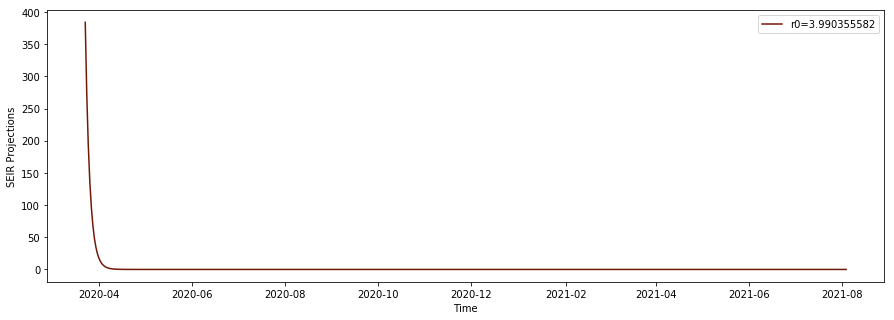

In [431]:
trials = Trials()
best = fmin(tuneParameters, search_space, algo=tpe.suggest, max_evals=1, trials = trials)
print("Best fit:", space_eval(search_space, best))

In [359]:
trialDict = dict()
for trial in trials:
    trialDict[(trial['misc']['vals']['EbyIRation'][0],trial['misc']['vals']['r0'][0])] = trial['result']['loss']

In [360]:
sortedTrialDict = [(k, v) for k, v in sorted(trialDict.items(), key=lambda item: item[1])]

In [361]:
sortedTrialDict
#E/I, r0, MAPE

[((26.406992708044353, 1.920590371447), 30.06235955937559),
 ((30.150758680541013, 3.8215428492748433), 30.06235955937559),
 ((42.473146018370095, 3.93578960356), 30.06235955937559),
 ((39.629728851707334, 3.9180512366940934), 30.06235955937559),
 ((40.120433754599716, 2.3442079797539606), 30.06235955937559),
 ((15.109247376574306, 3.2510244558055303), 30.06235955937559),
 ((12.10246063070004, 2.4825502328459703), 30.06235955937559),
 ((48.88182018353948, 3.1166665499463937), 30.06235955937559),
 ((34.47870272447646, 0.8067695905711225), 30.06235955937559),
 ((38.571967407472044, 3.087739261646494), 30.06235955937559),
 ((37.42854494582614, 1.2476344446922034), 30.06235955937559),
 ((18.41614462544694, 3.1916998523426923), 30.06235955937559),
 ((29.111016695971887, 1.068229324732066), 30.06235955937559),
 ((11.242745546179306, 3.513619260127024), 30.06235955937559),
 ((7.345039447382265, 3.8023115867230093), 30.06235955937559),
 ((33.608210073529214, 3.348846894050655), 30.062359559375

In [309]:
trial = list(trials)[0]

In [310]:
trial

{'book_time': datetime.datetime(2020, 3, 29, 19, 7, 32, 493000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'EbyIRation': [0], 'r0': [0]},
  'tid': 0,
  'vals': {'EbyIRation': [9.817434869537077], 'r0': [2.760156992294743]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2020, 3, 29, 19, 7, 32, 627000),
 'result': {'loss': 90.17362677837649, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 0,
 'version': 0}

In [145]:
region_timeseries_df = pd.read_csv('./time_series_covid19_confirmed_India_20200329.csv')
population_file = pd.read_csv('./state_population.csv')
population_file = population_file[['state', 'population']]
region_timeseries_df = region_timeseries_df.merge(population_file, right_on = "state", left_on = 'Province/State')
region_timeseries_df = region_timeseries_df.drop(['state', 'Lat', 'Long'], axis = 1)
region_timeseries_df = region_timeseries_df.groupby(['Country/Region']).agg('sum')

In [146]:
region_timeseries_df

,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,population
Country/Region,,,,,,,,,,,,,,,,,,,,
India,43.0,56.0,68.0,77.0,78.0,102.0,104.0,123.0,134.0,155.0,192.0,245.0,321.0,384.0,467.0,551.0,623.0,652.0,814.0,1198304026
